# EDA - Previsão de Energia

In [318]:
import os
import duckdb
import numpy as np
import pandas as pd
import seaborn as sns
import pymannkendall as mk
import plotly.express as px
from datetime import timedelta
from unidecode import unidecode
import matplotlib.pyplot as plt
from pmdarima.arima import CHTest
from statsmodels.tsa.stattools import adfuller

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
os.chdir('../')

## Leitura dos dados
Lê todos os parquets ignorando a colunas `CNAE`, pois a mesma não está presente em alguns arquivos. 

In [4]:
create_table_sql = """
    SELECT 
        "CNPJ da Carga" AS cnpj_carga, 
        "Capacidade da Carga (MW)" AS capacidade_carga_mw, 
        "Carga" AS carga, 
        "Cidade" AS cidade,
        "Classe do perfil do agente" AS classe_perfil_agente,
        "Consumo de energia ajustado da parcela cativa da carga parcialmente livre - MWh (RC_CAT c,j)" AS consumo_parcela_cativa,
        "Consumo de energia ajustado de uma parcela de carga - MWh (RC c,j)" AS consumo_parcela_carga,
        "Consumo de energia no ponto de conexão da parcela de carga - MWh (MED_C c,j)" AS consumo_ponto_conexao_parcela_carga,
        "Consumo no Ambiente Livre da parcela de carga - MWh (RC_AL c,j)" AS consumo_ambiente_livre_parcela_carga,
        "Cód. Carga" AS cod_carga, 
        "Cód. Perfil" AS cod_perfil, 
        "Cód. Perfil Distribuidora" AS cod_perfil_distribuidora, 
        "Data" AS data,
        "Data de Migração" AS data_migracao, 
        "Estado" AS estado,
        "HH" AS hora, 
        "Nome Empresarial" AS nome_empresarial,
        "Ramo de Atividade" AS ramo_atividade, 
        "Sigla" AS sigla, 
        "Sigla Perfil Distribuidora" AS sigla_perfil_distribuidora,
        "Submercado" AS submercado  
    FROM parquet_scan('data/raw/*.parquet')
"""

In [5]:
consumo = duckdb.sql(create_table_sql).df()

In [67]:
consumo.head()

,classe_perfil_agente,consumo_parcela_carga,consumo_ponto_conexao_parcela_carga,consumo_ambiente_livre_parcela_carga,cod_perfil,data,data_migracao,hora,sigla
0,Consumidor Especial,"0,11349000000000001","0,10970899999999999","0,11349000000000001",96928,2021-04-01,2020-08-01 03:00:00,"6,0",FCA ESPECIAL
1,Consumidor Especial,"0,122617","0,118656","0,122617",96928,2021-04-01,2020-08-01 03:00:00,"7,0",FCA ESPECIAL
2,Consumidor Especial,"0,13808399999999998","0,133792","0,13808399999999998",96928,2021-04-01,2020-08-01 03:00:00,"8,0",FCA ESPECIAL
3,Consumidor Especial,"0,148534","0,143558","0,148534",96928,2021-04-01,2020-08-01 03:00:00,"5,0",FCA ESPECIAL
4,Consumidor Especial,"0,148632","0,144137","0,148632",96928,2021-04-01,2020-08-01 03:00:00,"13,0",FCA ESPECIAL


# Dataprep

In [7]:
def list_columns_repeated_classes(dataframe):
  """
    List all columns with repeated classes in data
    
    Parameters
    -------------
    dataframe: pd.dataframe
        A pandas dataframe containing the data.

    Returns
    -------------
    columns_unwanted: list
        A list of variables unwanted according to repeated classes criterion.
  """
  columns_unwanted = []
  for column in dataframe.columns:
    value_counts_ = dataframe[column].value_counts()
    if dataframe[column].nunique() == 1:
      columns_unwanted.append(column)
    elif (value_counts_.values[0] == value_counts_).all() and (value_counts_.shape[0] == 3):
      columns_unwanted.append(column)
  return columns_unwanted

In [8]:
columns_repeated_class = list_columns_repeated_classes(consumo)

In [9]:
consumo = consumo.drop(columns = columns_repeated_class)

Seleção das variáveis de interesse.

In [21]:
consumo_reduced = consumo[
    [
        'sigla',
        'classe_perfil_agente',
        'data',
        'hora',
        'consumo_ambiente_livre_parcela_carga',
        'consumo_parcela_carga',
        'consumo_ponto_conexao_parcela_carga'
        ]
].copy()

### Transformação das variáveis para float

As variáveis abaixo devem ser analisadas como float, mas estão salvas como string separadas por ",". Iremos transformá-las.

In [23]:
string_to_float_columns = [
    'hora',
    'consumo_ambiente_livre_parcela_carga',
    'consumo_parcela_carga',
    'consumo_ponto_conexao_parcela_carga'
]

In [24]:
consumo_reduced[string_to_float_columns] = consumo_reduced[string_to_float_columns]\
.map(lambda x: x.replace(',', '.'))\
.astype(float)

### Transformação das variáveis de interesse em uma

**Obs.:** Via conhecimento de especialistas, trabalharemos com a soma das variáveis de consumo. No entanto, um estudo mais detalhado pode ser realizado, para isso, devemos resolver um problema de séries temporais multivariado.

In [25]:
consume_columns = consumo_reduced.filter(like = 'consumo').columns.tolist()

In [26]:
consumo_reduced['consumo'] = consumo_reduced.filter(like = 'consumo').sum(axis = 1)

In [27]:
consumo_reduced = consumo_reduced.drop(columns = consume_columns)

In [28]:
consumo_reduced

,sigla,classe_perfil_agente,data,hora,consumo
0,FCA ESPECIAL,Consumidor Especial,2021-04-01,6.0,0.336689
1,FCA ESPECIAL,Consumidor Especial,2021-04-01,7.0,0.363890
2,FCA ESPECIAL,Consumidor Especial,2021-04-01,8.0,0.409960
3,FCA ESPECIAL,Consumidor Especial,2021-04-01,5.0,0.440626
4,FCA ESPECIAL,Consumidor Especial,2021-04-01,13.0,0.441401
...,...,...,...,...,...
65803,FIAT AUTOCL 514 23,Consumidor Livre,2023-08-09,19.0,1.074097
65804,FIAT AUTOCL 514 23,Consumidor Livre,2023-08-09,20.0,1.027133
65805,FIAT AUTOCL 514 23,Consumidor Livre,2023-08-09,21.0,0.994397
65806,FIAT AUTOCL 514 23,Consumidor Livre,2023-08-09,22.0,1.008769


# Feature Engineering e Análise

### Transformação da série para o diário
Facultativamente decidida para o projeto, outras faixas de tempo podem ser consideradas em estudos futuros.

In [70]:
daily_consume = consumo_reduced\
.groupby(['sigla', 'classe_perfil_agente', 'data'])['consumo']\
.sum()\
.reset_index()

### Análise de dados faltantes
Busca por dados faltantes que causam lacunas na série e podem trazer problemas de quebra do processo estocástico.

Para esta verificação selecionamos as datas iniciais e finais com objetivo de criar uma série (pandas) com todos os dias dos meses ao longo desse intervalo. Em seguida, checamos se há algum valor faltando na nossa série temporal.

In [71]:
first_day = daily_consume['data'].min()
last_day = daily_consume['data'].max()

In [72]:
observational_temporal_interval = (last_day - first_day).days

In [131]:
timestamp_list = [first_day + timedelta(days=x) for x in range(observational_temporal_interval + 1)] 
timestamp_list = pd.Series(timestamp_list)

Identificamos que há um dia faltante na série temporal. Neste caso iremos imputar via interpolação.

In [137]:
missing_date = timestamp_list[~timestamp_list.isin(daily_consume['data'])]

Observamos que não há valores faltantes. Neste caso, interpolação não é necessário.

In [140]:
missing_date

Series([], dtype: datetime64[ns])

### Análise da distribuição de probabilidade

In [189]:
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

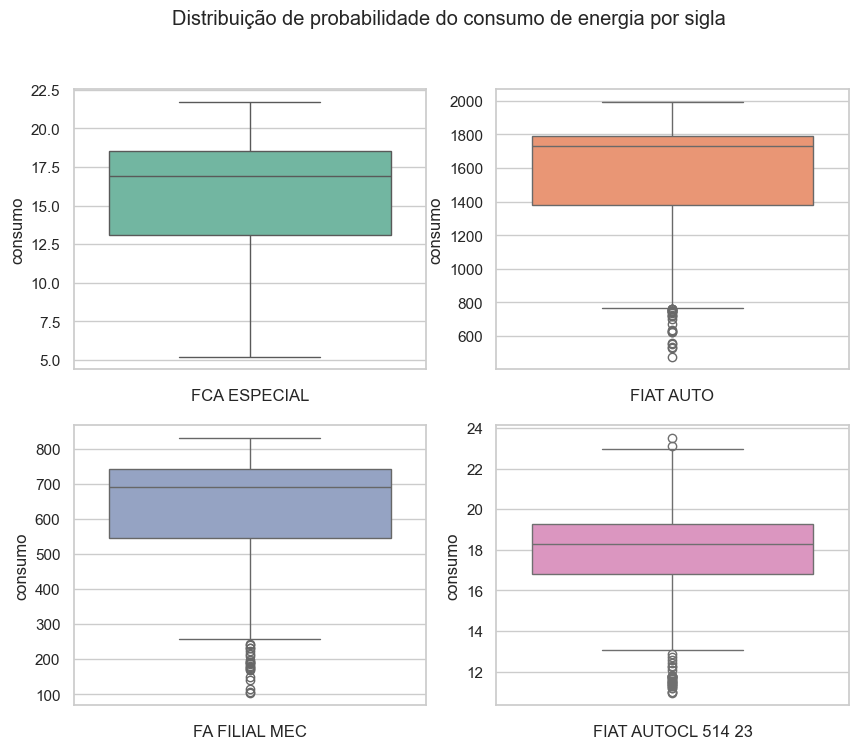

In [234]:
row_numbers = 2
col_numbers = 2
counter_ = 1

fig = plt.figure(figsize = (10,8))
plt.suptitle('Distribuição de probabilidade do consumo de energia por sigla')
for position, sigla in enumerate(consumo_reduced['sigla'].unique()):
    plt.subplot(row_numbers, col_numbers, counter_)
    plt.xlabel(sigla)
    sns.boxplot(
        data = daily_consume.query(f"""sigla == '{sigla}'"""), 
        y = 'consumo', 
        color = colors[position],
    );
    counter_ = counter_ + 1

Os histogramas apresentam assimetria e são multimodais em todas as siglas do estudo. Além disso, observamos a presença de alguns outliers, exceto para `FCA ESPECIAL`. Estes outliers merecem atenção, pois podem indicar padrões importante e serão melhor analisados nas próximas seções.

**Obs.:** Todas as figuras estão em escalas diferentes logo, não são diretamente comparáveis.

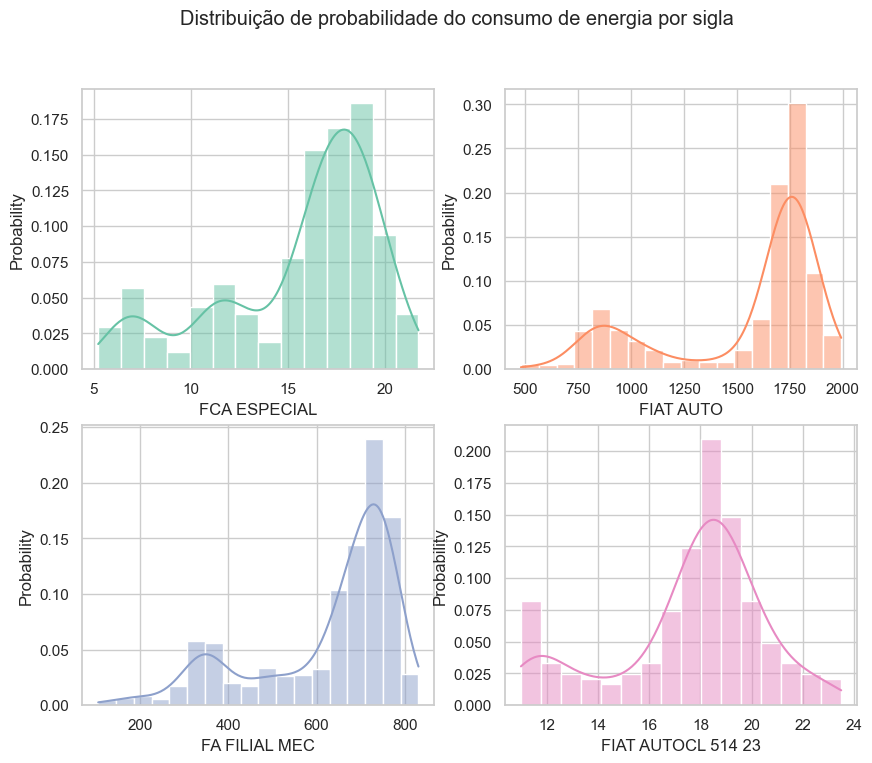

In [233]:
row_numbers = 2
col_numbers = 2
counter_ = 1

fig = plt.figure(figsize = (10,8))
plt.suptitle('Distribuição de probabilidade do consumo de energia por sigla')
for position, sigla in enumerate(consumo_reduced['sigla'].unique()):
    plt.subplot(row_numbers, col_numbers, counter_)
    plt.xlabel(sigla)
    sns.histplot(
        daily_consume.query(f"""sigla == '{sigla}'""")['consumo'],  
        color = colors[position],
        fill = True, 
        kde = True,
        stat = 'probability'
    
    );
    counter_ = counter_ + 1

### Visualização da série e seus componentes
Observamos que a empresa correspondente a série `FCA ESPECIAL` teve uma mudança de comportamento de consumo a partir de abril de 2022. É notório menor variação no consumo. Destacamos para `FIAT AUTO` e `FA FILIAL MEC` um comportamento diferente do padrão, vales encontrado ao longo da série determinados por dias específicos. A `FIAT AUTOCL 513 23`, por sua vez, possui uma oscilação sazonal e com tendência de crescimento.

**TODO -** investigar quais são os dias e se há alguma explicação além dos dados, e.g., na mídia. 

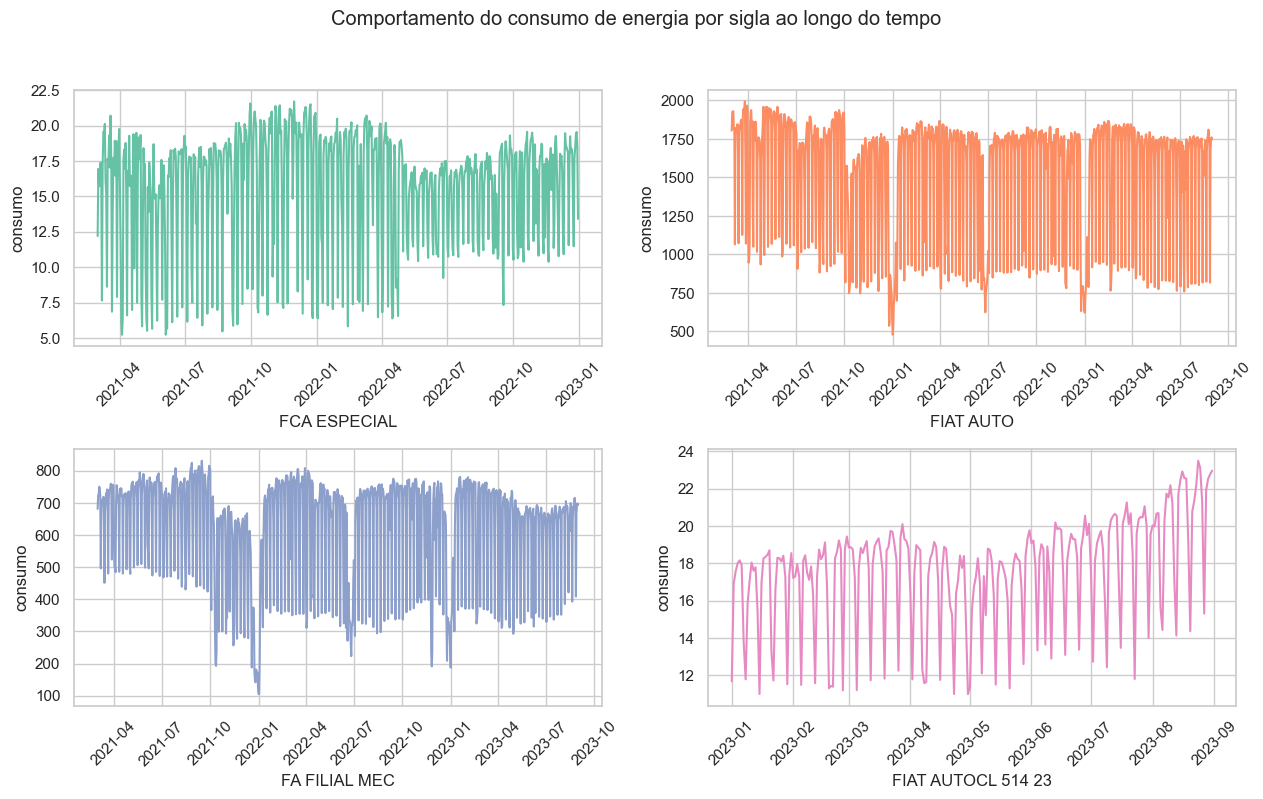

In [258]:
row_numbers = 2
col_numbers = 2
counter_ = 1

fig = plt.figure(figsize = (15, 8))
fig.subplots_adjust(hspace=.4)

plt.suptitle('Comportamento do consumo de energia por sigla ao longo do tempo')
for position, sigla in enumerate(consumo_reduced['sigla'].unique()):
    plt.subplot(row_numbers, col_numbers, counter_)
    plt.xlabel(sigla)
    plt.xticks(rotation=45)
    sns.lineplot(
        daily_consume.query(f"""sigla == '{sigla}'"""),
        x = 'data',
        y = 'consumo',
        color = colors[position],    
    );
    counter_ = counter_ + 1

### Testes de hipóteses

#### Estacionaridade

In [295]:
def stationarity_test(time_series, significance_level = .05):
    result = adfuller(time_series)
    adf_statistic = result[0]
    p_value = result[1]
    
    print(f"Estatística ADF: {adf_statistic}")
    print(f"P-valor: {np.round(p_value, 3)}")
    
    if p_value <= significance_level:
        print('A série é estacionária (rejeitamos a hipótese nula)\n')
    else:
        print('A série não é estacionária (não rejeitamos a hipótese nula)\n')

Pelo teste ADF (Augmented Dickey-Fuller), apenas a série `FIAT AUTOCL 514 23` não é estacionária. Visualmente também podemos observar que há uma tendência de crescimento na série. Neste caso, modelos do tipo ARIMA não funcionarão bem, pois supõem estacionariedade. Porém, a série pode ser transformada e apresentar tal propriedade.

In [305]:
for position, sigla in enumerate(consumo_reduced['sigla'].unique()):
    print(f'Estacionaridade de {sigla}')
    stationarity_test(daily_consume.query(f"""sigla == '{sigla}'""")['consumo'])

Estacionaridade de FCA ESPECIAL
Estatística ADF: -2.888378869521318
P-valor: 0.047
A série é estacionária (rejeitamos a hipótese nula)

Estacionaridade de FIAT AUTO
Estatística ADF: -5.120766930649473
P-valor: 0.0
A série é estacionária (rejeitamos a hipótese nula)

Estacionaridade de FA FILIAL MEC
Estatística ADF: -4.247964828870424
P-valor: 0.001
A série é estacionária (rejeitamos a hipótese nula)

Estacionaridade de FIAT AUTOCL 514 23
Estatística ADF: -0.12103741507947899
P-valor: 0.947
A série não é estacionária (não rejeitamos a hipótese nula)



#### Sazonalidade

De acordo com o teste de Canova-Hansen¹, apenas as séries `FIAT AUTO` e `FA FILIAL MEC` possuem comportamento sazonais diariamente. Neste caso, ambas as séries são mais facilmente previsíveis, além disso, médias móveis diárias podem ser variáveis importantes para estas séries. Finalmente, dois modelos SARIMA podem dar bons resultados.

¹ https://users.ssc.wisc.edu/~bhansen/papers/jbes_95.pdf

In [313]:
for position, sigla in enumerate(consumo_reduced['sigla'].unique()):
    print(f'Sazonalidade de {sigla}')
    results = CHTest(m=365).estimate_seasonal_differencing_term(
        daily_consume.query(f"""sigla == '{sigla}'""")['consumo']
    )
    print(results)

Sazonalidade de FCA ESPECIAL
0
Sazonalidade de FIAT AUTO
1
Sazonalidade de FA FILIAL MEC
1
Sazonalidade de FIAT AUTOCL 514 23
0


#### Tendência

Com objetivo de entender o comportamento da tendência de cada série, conduzimos 4 testes de hipóteses. Sendo dois específicos para séries que possuem tendência. De acordo com os testes realizados, apenas a série `FCA ESPECIAL` não apresenta tendência monotônica. Porém, `FIAT AUTO`, `FA FILIAL MEC` e `FIAT AUTOCL 514 23` apresenta tendência de decrescimento, decrescimento e crescimento, respectivamente.

Visão técnica:
- Hamed and Rao Modified MK Test: corrige os problemas de autocorrelação serial e correção da variância para melhoria da qualidade do teste (veja Yue, S., & Wang, C. Y. (2004));
- Seasonal test: Destinado a tendência na presença de sazonalidade (veja Hirsch, R.M., Slack, J.R. and Smith, R.A. (1982))

In [329]:
tendency_test = mk.hamed_rao_modification_test(
    daily_consume.query(f"""sigla == 'FCA ESPECIAL'""")['consumo']
)

print('p-value: ', np.round(tendency_test.p, 3))
print('tendency type: ', tendency_test.trend)

p-value:  0.957
tendency type:  no trend


In [327]:
tendency_with_seasonality_test = mk.seasonal_test(
    daily_consume.query(f"""sigla == 'FIAT AUTO'""")['consumo'], 
    period = 365
)

print('p-value: ', np.round(tendency_with_seasonality_test.p, 3))
print('tendency type: ', tendency_with_seasonality_test.trend)

p-value:  0.002
tendency type:  decreasing


In [328]:
tendency_with_seasonality_test = mk.seasonal_test(
    daily_consume.query(f"""sigla == 'FA FILIAL MEC'""")['consumo'], 
    period = 365
)

print('p-value: ', np.round(tendency_with_seasonality_test.p, 3))
print('tendency type: ', tendency_with_seasonality_test.trend)

p-value:  0.0
tendency type:  decreasing


In [330]:
tendency_test = mk.hamed_rao_modification_test(
    daily_consume.query(f"""sigla == 'FIAT AUTOCL 514 23'""")['consumo']
)

print('p-value: ', np.round(tendency_test.p, 3))
print('tendency type: ', tendency_test.trend)

p-value:  0.002
tendency type:  increasing


### Considerações

A partir desta seção, as 4 séries foram analisadas separadamente.

## TODO - Feature Engineering

- Feriados: https://github.com/joaopbini/feriados-brasil/tree/master/dados/feriados/nacional/csv

In [332]:
daily_consume_enriched = daily_consume.copy()

In [333]:
daily_consume_enriched.head()

,sigla,classe_perfil_agente,data,consumo
0,FA FILIAL MEC,Consumidor Livre,2021-03-01,680.982923
1,FA FILIAL MEC,Consumidor Livre,2021-03-02,723.321318
2,FA FILIAL MEC,Consumidor Livre,2021-03-03,725.915940
3,FA FILIAL MEC,Consumidor Livre,2021-03-04,750.007136
4,FA FILIAL MEC,Consumidor Livre,2021-03-05,743.864293


### Features extraídas a partir da data da série

Considerando exclusivamente a data dos eventos, extraímos algumas features que podem ser importantes para a modelagem. Além disso, essas features ajudaram a entender alguns padrões de consumo como será visto mais adiante.

In [500]:
def create_date_features(date_series):
    day = date_series.dt.day
    year = date_series.dt.year
    week = date_series.dt.isocalendar().week
    month = date_series.dt.month
    quarter = date_series.dt.quarter
    weekday = date_series.dt.weekday
    day_of_year = date_series.dt.day_of_year
    is_weekend = weekday.isin([5, 6]).astype(int)
    is_month_end = date_series.dt.is_month_end.astype(int)

    return pd.DataFrame(
        {
            'day':day,
            'year':year,
            'week':week,
            'month':month,
            'quarter':quarter,
            'weekday':weekday,
            'day_of_year':day_of_year,
            'is_weekend':is_weekend,
            'is_month_end': is_month_end
        }
    )

def extract_rolling_statistics(date_series, window_size):
    rolling_mean  = date_series.rolling(window=window_size).mean()
    rolling_std = date_series.rolling(window=window_size).std()
    rolling_min = date_series.rolling(window=window_size).min()
    rolling_max = date_series.rolling(window=window_size).max()
    rolling_kurtosis = date_series.rolling(window=window_size).kurt()
    rolling_skewness = date_series.rolling(window=window_size).skew()

    return pd.DataFrame(
        {
            f'rolling_mean_{window_size}': rolling_mean,
            f'rolling_std_{window_size}': rolling_std,
            f'rolling_min_{window_size}': rolling_min,
            f'rolling_max_{window_size}': rolling_max,
            f'rolling_kurtosis_{window_size}': rolling_kurtosis,
            f'rolling_skewness_{window_size}': rolling_skewness
        }
    )

def extract_lag_features(date_series, max_lag):
    dict_lag = {}
    for lag in range(max_lag):
        dict_lag[f'lag_{lag}'] = date_series.shift(lag + 1)
    return pd.DataFrame(dict_lag)

def extract_features(data, response_variable, categorical_variable, date_variable):
    dict_enriched_data = {}
    for cat in data[categorical_variable].unique():
        data_filtered = data.query(f"""{categorical_variable} == '{cat}'""")\
        .reset_index(drop=True).copy()        
        
        response_temp = data_filtered[response_variable] 
        data_features_window_1 = extract_rolling_statistics(response_temp, 1)
        data_features_window_7 = extract_rolling_statistics(response_temp, 7)        
        data_features_lag = extract_lag_features(response_temp, 3)

        date_features = create_date_features(data_filtered[date_variable])
        
        data_temp = pd.concat(
            [
                data_filtered, date_features, data_features_window_1,  
                data_features_window_7, data_features_lag
            ], 
            axis = 1
        )
    
        dict_enriched_data[f'{cat}'] = data_temp
    return dict_enriched_data

def remove_columns_with_missing_data(data, threshold=0.5):
    missing_percentage = data.isnull().mean()
    selected_columns = missing_percentage[missing_percentage < threshold].index

    data_cleaned = data[selected_columns]
    return data_cleaned

In [501]:
time_series_enriched = extract_features(daily_consume_enriched, 'consumo', 'sigla', 'data')

In [502]:
for key, value in time_series_enriched.items():
    time_series_enriched[key] = remove_columns_with_missing_data(value)\
    .dropna()

In [503]:
time_series_enriched.get('FA FILIAL MEC')

,sigla,classe_perfil_agente,data,consumo,day,year,week,month,quarter,weekday,day_of_year,is_weekend,is_month_end,rolling_mean_1,rolling_min_1,rolling_max_1,rolling_mean_7,rolling_std_7,rolling_min_7,rolling_max_7,rolling_kurtosis_7,rolling_skewness_7,lag_0,lag_1,lag_2
6,FA FILIAL MEC,Consumidor Livre,2021-03-07,495.939270,7,2021,9,3,1,6,66,1,0,495.939270,495.939270,495.939270,691.550938,89.047500,495.93927,750.007136,5.632438,-2.328181,720.825689,743.864293,750.007136
7,FA FILIAL MEC,Consumidor Livre,2021-03-08,684.823887,8,2021,10,3,1,0,67,0,0,684.823887,684.823887,684.823887,692.099648,88.983337,495.93927,750.007136,5.779941,-2.358831,495.939270,720.825689,743.864293
8,FA FILIAL MEC,Consumidor Livre,2021-03-09,704.339671,9,2021,10,3,1,1,68,0,0,704.339671,704.339671,704.339671,689.387984,88.158720,495.93927,750.007136,5.613603,-2.306149,684.823887,495.939270,720.825689
9,FA FILIAL MEC,Consumidor Livre,2021-03-10,710.109022,10,2021,10,3,1,2,69,0,0,710.109022,710.109022,710.109022,687.129853,87.265052,495.93927,750.007136,5.575028,-2.283007,704.339671,684.823887,495.939270
10,FA FILIAL MEC,Consumidor Livre,2021-03-11,711.537928,11,2021,10,3,1,3,70,0,0,711.537928,711.537928,711.537928,681.634251,83.787355,495.93927,743.864293,6.039491,-2.396150,710.109022,704.339671,684.823887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,FA FILIAL MEC,Consumidor Livre,2023-08-27,408.639100,27,2023,34,8,3,6,239,1,0,408.639100,408.639100,408.639100,648.340957,107.923654,408.63910,714.968660,6.103248,-2.425095,681.000155,714.968660,713.872187
910,FA FILIAL MEC,Consumidor Livre,2023-08-28,666.643893,28,2023,35,8,3,0,240,0,0,666.643893,666.643893,666.643893,650.568540,108.149596,408.63910,714.968660,6.411849,-2.495323,408.639100,681.000155,714.968660
911,FA FILIAL MEC,Consumidor Livre,2023-08-29,693.662528,29,2023,35,8,3,1,241,0,0,693.662528,693.662528,693.662528,651.483490,108.538115,408.63910,714.968660,6.416429,-2.498437,666.643893,408.639100,681.000155
912,FA FILIAL MEC,Consumidor Livre,2023-08-30,698.071309,30,2023,35,8,3,2,242,0,0,698.071309,698.071309,698.071309,653.836833,109.474437,408.63910,714.968660,6.454205,-2.512054,693.662528,666.643893,408.639100
